In [11]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from time import time
from abc import ABC, abstractmethod

In [12]:

class GBMSobolPathGenerator:
    def __init__(self, n_steps,log2_n_paths,S0,T,r,q,sigma):
        """
        n_steps : dimensionality / number of increments
        n_paths : number of paths
        S0: initial stock price
        T : maturity
        r : risk free interest rate
        q : divident rate
        sigma : stock volatility
        """
        n_paths = 2**log2_n_paths
        times = np.linspace(0., T, n_steps)
        dt = times[1] - times[0]
        self.dt = dt
        timesArray = np.repeat(times.reshape(n_steps,1), n_paths, axis = 1)
        # Bt2 - Bt1 ~ Normal with mean 0 and variance t2-t1
        dB = np.zeros((n_steps, n_paths))

        # SOBOL Random Number Generator

        SobolArray = sp.stats.qmc.Sobol(d=n_steps-1).random_base2(m=log2_n_paths)  # n_paths = 2^m
        randomArray = sp.stats.norm.ppf(SobolArray)
        dB[1:, :] = np.sqrt(dt) * randomArray.transpose()

        # Simulation of Arithmetic brownian motion
        B = np.cumsum(dB, axis=0)
        S = S0*np.exp((r-q-sigma**2/2)*timesArray + sigma*B)
        self.S = S


In [38]:
class StockMovementGenerator(ABC):
    """Abstract base class for generating stock price movements"""

    def __init__(self, initial_price: float, n_steps: int, n_paths : int, T:float):
        self.initial_price = initial_price
        self.n_steps = n_steps # Dimensionality of Monte Carlo / Number of Increments
        self.n_paths = n_paths # Number of Iterations / Paths
        self.T = T  # Timespan
        self.dt = self.T/(self.n_steps-1)

    @abstractmethod
    def generate(self):
        """Generate price movements"""
        pass

class GeometricBrownianMotion(StockMovementGenerator):
    """Generate stock prices using Geometric Brownian Motion"""

    def __init__(self, initial_price: float, n_steps: int, n_paths : int,
                 r: float, q:float, sigma: float , T: float):
        super().__init__(initial_price, n_steps, n_paths, T)
        self.S0 = initial_price # Initial stock price
        self.r = r  # Risk-free interest rate
        self.q = q # Dividend rate
        self.sigma = sigma  # volatility
        self.times = np.linspace(0., self.T, self.n_steps)
        self.timesArray = np.repeat(self.times.reshape(n_steps,1), n_paths, axis = 1)

    def generate(self):
        """
        Generate prices using GBM
        The generator function can take in a changing volatility

        """
        # Bt2 - Bt1 ~ Normal with mean 0 and variance t2-t1
        dB = np.zeros((self.n_steps, self.n_paths))
        dB[1:, :] = np.sqrt(self.dt) * np.random.normal(size=(self.n_steps-1, self.n_paths))
        # Simulation of Arithmetic brownian motion
        B = np.cumsum(dB, axis=0)
        S = self.S0*np.exp((self.r-self.q-self.sigma**2/2)*self.timesArray + self.sigma*B)
        return S

class SobolGeometricBrownianMotion(StockMovementGenerator):
    """Generate stock prices using Geometric Brownian Motion"""

    def __init__(self, initial_price: float, n_steps: int, n_paths : int,
                 r: float, q:float, sigma: float , T: float):
        super().__init__(initial_price, n_steps, n_paths, T)
        self.S0 = initial_price # Initial stock price
        self.r = r  # Risk-free interest rate
        self.q = q # Dividend rate
        self.sigma = sigma  # volatility
        self.times = np.linspace(0., self.T, self.n_steps)
        self.timesArray = np.repeat(self.times.reshape(n_steps,1), n_paths, axis = 1)

    def generate(self):

        # Bt2 - Bt1 ~ Normal with mean 0 and variance t2-t1
        dB = np.zeros((self.n_steps, self.n_paths))

        # SOBOL Random Number Generator

        SobolArray = sp.stats.qmc.Sobol(d=self.n_steps-1).random_base2(m=int(np.log2(self.n_paths)))  # n_paths = 2^m
        randomArray = sp.stats.norm.ppf(SobolArray)
        dB[1:, :] = np.sqrt(self.dt) * randomArray.transpose()

        # Simulation of Arithmetic brownian motion
        B = np.cumsum(dB, axis=0)
        S = S0*np.exp((self.r-self.q-self.sigma**2/2)*self.timesArray + self.sigma*B)

        return S

In [37]:
def checkConvergence(derivativePayoff, GBMgenerator, frequency, T, r, q, sigma , minPower, maxPower, filterFunction = None, Nexp = 10):
    """Check for convergence of derivative price

    GBMgenerator : the class generating the Geometric Brownian Motion paths
    derivativePayoff : function that returns the derivative payoff
    frequency : number of setting dates per year
    T : time to maturity
    r : risk free interest rate
    sigma : volatility
    """
    _priceArray = np.zeros((Nexp,maxPower - minPower))
    _priceMean = np.zeros(maxPower - minPower)
    _priceStd = np.zeros(maxPower - minPower)

    n_steps = frequency*T

    for idx,k in enumerate(range(minPower,maxPower)):

        for j in range(Nexp):
            n_paths = np.power(2,k)
            GBM = GBMgenerator(S0, n_steps, n_paths, r, q, sigma, T)
            S = GBM.generate()

            if filterFunction is not None:
                S = filterFunction(S)

            _priceArray[j,idx] = np.mean(derivativePayoff(S))*np.exp(-r*T)

    _priceMean = np.mean(_priceArray, axis = 0)
    _priceStd = np.std(_priceArray, axis = 0)
    return  _priceMean, _priceStd


In [17]:
def asianOptionPayoff(array, K):
    return np.maximum(np.mean(array,axis = 0) - K, 0)

def EuropeanCallOptionPayoff(array, K):
    return np.maximum(array - K,0)

def EuropeanPutOptionPayoff(array, K):
    return np.maximum(K - array,0)


# Pricing Asian options

The payoff function for Asian options is $ \large( \frac{1}{n} \sum_{j=1}^{N} S_{t_j} - K \large)_{+} $ for time $t_n$

In other words, the payoff is a function of the average stock price until maturity

In [29]:
t = 0
K = 103
S0 = 100
q = 0.03
T = 1
sigma = .1
r = .05
minPower = 4
maxPower = 13

i) Maturity of 1 year and weekly setting dates

In [30]:
pathsArray = np.power(2,range(minPower,maxPower))

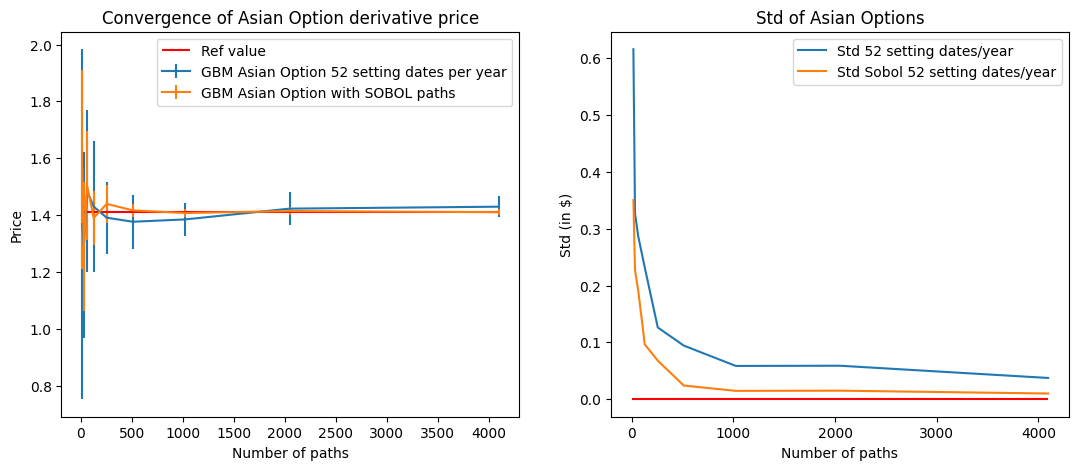

In [39]:
freq = 52
priceMean52, priceStd52 = checkConvergence(lambda x: asianOptionPayoff(x, K) , GeometricBrownianMotion , frequency=freq, T=T, q= q, r=r, sigma=sigma, minPower = minPower, maxPower = maxPower)
SobolMean52, SobolStd52 = checkConvergence(lambda x: asianOptionPayoff(x, K) , SobolGeometricBrownianMotion , frequency=freq, T=T, q= q, r=r, sigma=sigma, minPower = minPower, maxPower = maxPower)

fig,ax = plt.subplots(1,2, figsize=(13,5))
ax[0].errorbar(pathsArray, priceMean52, yerr = priceStd52, label = f'GBM Asian Option {freq} setting dates per year')
ax[1].plot(pathsArray, priceStd52, label = f"Std {freq} setting dates/year")

ax[0].errorbar(pathsArray, SobolMean52, yerr = SobolStd52, label = f'GBM Asian Option with SOBOL paths')
ax[1].plot(pathsArray, SobolStd52, label = f"Std Sobol {freq} setting dates/year")

ax[0].set_title('Convergence of Asian Option derivative price')
ax[0].set_xlabel('Number of paths')
ax[0].hlines(xmin = pathsArray[0], xmax = pathsArray[-1], y =1.41, color = 'red', label='Ref value')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[1].set_title('Std of Asian Options')
ax[1].set_xlabel('Number of paths')
ax[1].set_ylabel(r'Std (in \$)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()

# An improvement is visible

# Spectral Decomposition

In [62]:

class SpectralGeometricBrownianMotion(StockMovementGenerator):
    """Generate stock prices using Geometric Brownian Motion"""

    def __init__(self, initial_price: float, n_steps: int, n_paths : int,
                 r: float, q:float, sigma: float , T: float):
        super().__init__(initial_price, n_steps, n_paths, T)
        self.S0 = initial_price # Initial stock price
        self.r = r  # Risk-free interest rate
        self.q = q # Dividend rate
        self.sigma = sigma  # volatility
        self.times = np.linspace(0., self.T, self.n_steps)
        self.timesArray = np.repeat(self.times.reshape(n_steps,1), n_paths, axis = 1)

    def generate(self):

        # Bt2 - Bt1 ~ Normal with mean 0 and variance t2-t1
        dB = np.zeros((self.n_steps, self.n_paths))

        # SOBOL Random Number Generator

        SobolArray = sp.stats.qmc.Sobol(d=self.n_steps).random_base2(m=int(np.log2(self.n_paths)))  # n_paths = 2^m
        Z = sp.stats.norm.ppf(SobolArray).transpose() # Inverse Cumulative Distribution Function

        # Z are random independent samples

        W = np.zeros((self.n_steps, self.n_paths))

        # Compute variance matrix W_ij = min(i,j)
        lowTri = np.tril(np.ones((self.n_steps,self.n_steps)))
        cov = lowTri@lowTri.transpose()-np.ones((self.n_steps,self.n_steps))

        # Spectral decomposition
        _eig = np.linalg.eig(cov)
        P = _eig.eigenvectors
        D_half = np.diag(np.sqrt(_eig.eigenvalues))
        A = P@D_half@P.transpose()

        W = np.sqrt(self.dt)*A@Z
        S = self.S0*np.exp((self.r-self.q-self.sigma**2/2)*self.timesArray + self.sigma*W)


        return S

#Reversal Spectral Decomposition

In [63]:

class ReverseOrderSpectralGeometricBrownianMotion(StockMovementGenerator):
    """Generate stock prices using Geometric Brownian Motion"""

    def __init__(self, initial_price: float, n_steps: int, n_paths : int,
                 r: float, q:float, sigma: float , T: float):
        super().__init__(initial_price, n_steps, n_paths, T)
        self.S0 = initial_price # Initial stock price
        self.r = r  # Risk-free interest rate
        self.q = q # Dividend rate
        self.sigma = sigma  # volatility
        self.times = np.linspace(0., self.T, self.n_steps)
        self.timesArray = np.repeat(self.times.reshape(n_steps,1), n_paths, axis = 1)

    def generate(self):

        # Bt2 - Bt1 ~ Normal with mean 0 and variance t2-t1
        dB = np.zeros((self.n_steps, self.n_paths))

        # SOBOL Random Number Generator

        SobolArray = sp.stats.qmc.Sobol(d=self.n_steps).random_base2(m=int(np.log2(self.n_paths)))  # n_paths = 2^m
        Z = sp.stats.norm.ppf(SobolArray).transpose() # Inverse Cumulative Distribution Function

        # Z are random independent samples

        W = np.zeros((self.n_steps, self.n_paths))

        # Compute variance matrix W_ij = min(i,j)
        lowTri = np.tril(np.ones((self.n_steps,self.n_steps)))
        cov = lowTri@lowTri.transpose()-np.ones((self.n_steps,self.n_steps))

        # Spectral decomposition
        _eig = np.linalg.eig(cov)

        # Flipped eigenvectors
        P = np.flip(np.flip(_eig.eigenvectors, axis =0),axis =1)
        # Flipped eigvals
        _eigvals = np.flip(_eig.eigenvalues)


        D_half = np.diag(np.sqrt(_eigvals))
        A = P@D_half@P.transpose()

        W = np.sqrt(self.dt)*A@Z
        S = self.S0*np.exp((self.r-self.q-self.sigma**2/2)*self.timesArray + self.sigma*W)


        return S

#Brownian Bridge

In [64]:
def find_middle_element(arr):
    n = len(arr)

    # Check if the size of the list is even or odd
    if n % 2 == 0:
        # I make a deliberate choice in picking a middle
        idx = n // 2 - 1
        return idx, arr[idx]
    else:
        idx = n // 2
        return idx, arr[idx]


def BrownianBridgeOrdering(n_steps):

    arr = list(range(1,n_steps+1))
    res = [arr[-1]]
    arr.pop(-1)

    setsList = [arr]
    setsSizes = [len(arr)]

    while len(arr) > 0:

        # Select largest remaining set
        maxSetIdx = np.array(setsSizes).argmax()
        maxSet = setsList[maxSetIdx]
        # Take middle of remaining array

        middleIdx, middle = find_middle_element(maxSet)

        res.append(middle)

        # Split the set accordingly


        setsList.pop(maxSetIdx)

        # Store the remaining sets
        a = maxSet[middleIdx+1:]
        b = maxSet[:middleIdx]
        if(len(b)!=0):
            setsList.append(b)
        if(len(a)!=0):
            setsList.append(a)

        arr.pop(middleIdx)

        setsSizes = [len(item) for item in setsList]

        # Sort the sets

        orderedIdx = np.argsort(setsSizes)[::-1]

        setsList = [setsList[i] for i in orderedIdx]
        setsSizes = [setsSizes[i] for i in orderedIdx]

    return np.array(res)


class BrownianBridgeGeometricBrownianMotion(StockMovementGenerator):
    """Generate stock prices using Geometric Brownian Motion"""

    def __init__(self, initial_price: float, n_steps: int, n_paths : int,
                 r: float, q:float, sigma: float , T: float):
        super().__init__(initial_price, n_steps, n_paths, T)
        self.S0 = initial_price # Initial stock price
        self.r = r  # Risk-free interest rate
        self.q = q # Dividend rate
        self.sigma = sigma  # volatility
        self.times = np.linspace(0., self.T, self.n_steps)
        self.timesArray = np.repeat(self.times.reshape(n_steps,1), n_paths, axis = 1)

    def generate(self):

        # Bt2 - Bt1 ~ Normal with mean 0 and variance t2-t1
        dB = np.zeros((self.n_steps, self.n_paths))

        # SOBOL Random Number Generator

        SobolArray = sp.stats.qmc.Sobol(d=self.n_steps).random_base2(m=int(np.log2(self.n_paths)))  # n_paths = 2^m
        Z = sp.stats.norm.ppf(SobolArray).transpose() # Inverse Cumulative Distribution Function

        # Z are random independent samples

        W = np.zeros((self.n_steps, self.n_paths))

        # Compute variance matrix W_ij = min(i,j)
        lowTri = np.tril(np.ones((self.n_steps,self.n_steps)))
        cov = lowTri@lowTri.transpose()-np.ones((self.n_steps,self.n_steps))

        # Spectral decomposition
        _eig = np.linalg.eig(cov)

        ordArgs = BrownianBridgeOrdering(self.n_steps) - 1

        # Brownian Bridge eigenvectors
        P = _eig.eigenvectors
        P = P[:,ordArgs]
        # Brownian Bridge eigvals
        _eigvals = _eig.eigenvalues[ordArgs]

        D_half = np.diag(np.sqrt(_eigvals))
        A = P@D_half@P.transpose()

        W = np.sqrt(self.dt)*A@Z
        S = self.S0*np.exp((self.r-self.q-self.sigma**2/2)*self.timesArray + self.sigma*W)

        return S

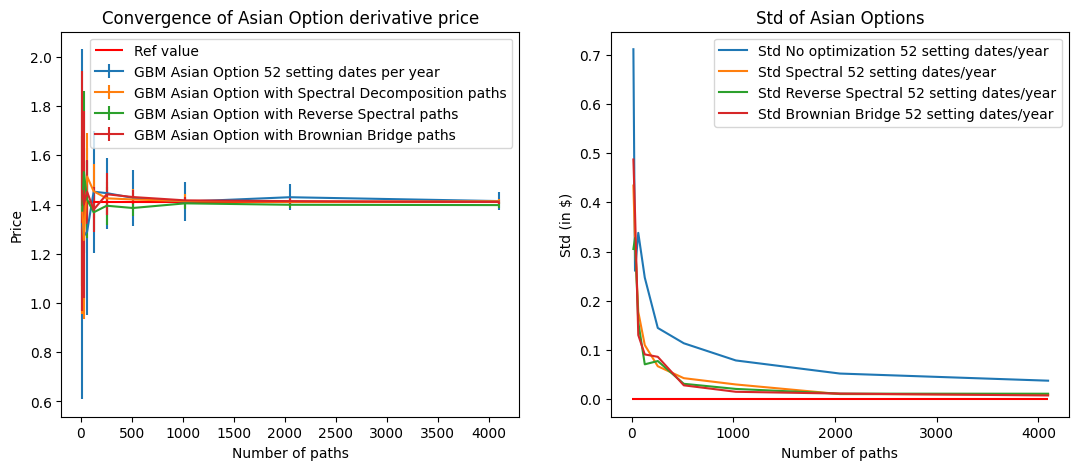

In [74]:
freq = 52
priceMean52, priceStd52 = checkConvergence(lambda x: asianOptionPayoff(x, K) , GeometricBrownianMotion , frequency=freq, T=T, q= q, r=r, sigma=sigma, minPower = minPower, maxPower = maxPower)
SpectralMean52, SpectralStd52 = checkConvergence(lambda x: asianOptionPayoff(x, K) , SpectralGeometricBrownianMotion , frequency=freq, T=T, q= q, r=r, sigma=sigma, minPower = minPower, maxPower = maxPower)
ReverseSpectralMean52, ReverseSpectralStd52 = checkConvergence(lambda x: asianOptionPayoff(x, K) , ReverseOrderSpectralGeometricBrownianMotion , frequency=freq, T=T, q= q, r=r, sigma=sigma, minPower = minPower, maxPower = maxPower)
BrownianBridgeMean52, BrownianBridgeStd52 = checkConvergence(lambda x: asianOptionPayoff(x, K) , BrownianBridgeGeometricBrownianMotion , frequency=freq, T=T, q= q, r=r, sigma=sigma, minPower = minPower, maxPower = maxPower)

fig,ax = plt.subplots(1,2, figsize=(13,5))
ax[0].errorbar(pathsArray, priceMean52, yerr = priceStd52, label = f'GBM Asian Option {freq} setting dates per year')
ax[1].plot(pathsArray, priceStd52, label = f"Std No optimization {freq} setting dates/year")

ax[0].errorbar(pathsArray, SpectralMean52, yerr = SpectralStd52, label = f'GBM Asian Option with Spectral Decomposition paths')
ax[1].plot(pathsArray, SpectralStd52, label = f"Std Spectral {freq} setting dates/year")

ax[0].errorbar(pathsArray, ReverseSpectralMean52, yerr = ReverseSpectralStd52, label = f'GBM Asian Option with Reverse Spectral paths')
ax[1].plot(pathsArray, ReverseSpectralStd52, label = f"Std Reverse Spectral {freq} setting dates/year")

ax[0].errorbar(pathsArray, BrownianBridgeMean52, yerr = BrownianBridgeStd52, label = f'GBM Asian Option with Brownian Bridge paths')
ax[1].plot(pathsArray, BrownianBridgeStd52, label = f"Std Brownian Bridge {freq} setting dates/year")

ax[0].set_title('Convergence of Asian Option derivative price')
ax[0].set_xlabel('Number of paths')
ax[0].hlines(xmin = pathsArray[0], xmax = pathsArray[-1], y =1.41, color = 'red', label='Ref value')
ax[0].legend()
ax[0].set_ylabel('Price')
ax[1].set_title('Std of Asian Options')
ax[1].set_xlabel('Number of paths')
ax[1].set_ylabel(r'Std (in \$)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,maxPower-1))
ax[1].legend()
fig.show()